In [7]:
#-----------------------------------------
# Problem Set 2: Q1 - Static Entry Model
#   Tanya Rajan and George Vojta
#
# We would like to thank Jeanne Sorin,
# Michael Cuna, Alex Petrov, & Nadia Lucas 
# for helpful comments on our code
#-----------------------------------------

# importing packages
import numpy as np
import pandas as pd
import scipy
from scipy.optimize import fsolve
from scipy.stats import logistic
from scipy.stats import expon
from scipy.special import expit
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns

In [65]:
# ------------------------
#     Question 1.3.2
# ------------------------

# Calculate jacobian for Newton's method
def BNE_jac(p_init, α, δ, x):
    inner1 = x*α - δ*p_init[1]
    inner2 = x*α - δ*p_init[0]
    J11 = -1
    J12 = -δ*(1-expit(-inner1))*(expit(-inner1))
    J21 = -δ*(1-expit(-inner2))*(expit(-inner2))
    J22 = -1
    J = np.array((J11, J12, J21, J22), dtype=float).reshape(2,2)
    
    return J
        
#J_test = BNE_jac(np.array((.3, .6)), 1,1, 1)
#J_test

# Objective function
def BNE_obj(p_init, α, δ, x):
    inner1 = x*α - δ*p_init[1]
    inner2 = x*α - δ*p_init[0]
    f1 =  1 - expit(-inner1) - p_init[0]
    f2 =  1 - expit(-inner2) - p_init[1]
    
    # calculating p_it
    return np.array([f1, f2], dtype=float)

#f_test = BNE_obj(np.array((.2,.8)), 1,1, 1)
#f_test


# Using Newton's method to solve for BNE given start values 
def BNE_solver(p_init, α, δ, x, maxiter, tol):
    counter = 1
    diff = 1
    p_new = p_init.reshape((2,1))
    while (diff > tol and counter < maxiter):
        # Newton's method
        p_old = p_new
        J = BNE_jac(p_old, α, δ, x)
        f = BNE_obj(p_old, α, δ, x)
        #p_new = np.linalg.solve(J, J @ p_old - f)
        p_new = p_old - np.linalg.inv(J)@f
        
        # make sure new values are in the range of interest
        p_new[p_new > 1] = 1
        p_new[p_new < 0] = 0
        
        # compute difference
        diff = np.max(np.abs(p_new - p_old))
        counter += 1
    return p_new.flatten()

#BNE_solver(np.array((.3, .6)), 1, 1, 1, 10000, 10e-20)


# Using hand-coded Newton method to find all eqs (fairly slow)
def BNE_findall_0(α, δ, x, maxiter=10000, tol=10e-12, sym=False):
    # Grid search for multiple equilibria with different start values
    looper = lambda p: BNE_solver(p, α, δ, x, maxiter, tol)
    grid =  np.mgrid[0:1:1e-1, 0:1:1e-1].reshape(2,-1).T
    sols = np.round(np.apply_along_axis(looper, 1, grid),6)
    eqs = np.unique(sols, axis=0)
    
    # Find symmetric eq only 
    if sym == True:
        return eqs[np.argmin(np.abs(eqs[:,0] - eqs[:,1])), :]
    
    return eqs

# Find all Bayesian Nash eq using inbuilt solver (faster version)
def BNE_findall(α, δ, x, sym=False):
    # Grid search for multiple equilibria with different start values
    bne_p = lambda p: BNE_obj(p, α, δ, x)
    looper = lambda p0: fsolve(bne_p, p0)
    grid =  np.mgrid[0:1:1e-1, 0:1:1e-1].reshape(2,-1).T
    sols = np.round(np.apply_along_axis(looper, 1, grid),6)
    eqs = np.unique(sols, axis=0)
    
    # Find symmetric eq only 
    if sym == True:
        return eqs[np.argmin(np.abs(eqs[:,0] - eqs[:,1])), :]
    
    return eqs

BNE_findall_0(2,2,1)

In [71]:
# ------------------------
#     Question 1.3.3
# ------------------------

# Set parameters
α_set = 3
δ_set = 6
T = 1000
S = 50
np.random.seed(463)

##### Simulate Data #####

# Simulate epsilons and X
ϵ1_sim = np.random.logistic(0, 1, T*S).reshape(T,S)
ϵ2_sim = np.random.logistic(0, 1, T*S).reshape(T,S)
x_sim = (np.random.binomial(1,.5, T*S) + 1).reshape(T,S)

# function to find equilibria for each x value
def findps(α, δ, sym=False):
    p_x1 = BNE_findall(α, δ, 1, sym=sym)
    p_x2 = BNE_findall(α, δ, 2, sym=sym)
    return p_x1, p_x2

# Calculating expectations of other firm's entry (symmetric)
p_x1_sim, p_x2_sim = findps(α_set, δ_set, sym=True)
probs_sim = np.zeros((T,S))
probs_sim[x_sim == 1] = p_x1_sim[0]
probs_sim[x_sim == 2] = p_x2_sim[0]
print(p_x1_sim, p_x2_sim)

# Calculating y
y1u_sim = np.array((-δ_set*probs_sim + α_set*x_sim + ϵ1_sim >= 0)*1)
y2u_sim = np.array((-δ_set*probs_sim + α_set*x_sim + ϵ2_sim >= 0)*1)


[0.5 0.5] [0.784577 0.784577]


In [70]:
##### Log Likelihood #####

# log lik function for symmetric eq
def sym_lik(ω, y1, y2, x):
    # parse ω
    α = ω[0]
    δ = ω[1]
    
    # calculating P's for each x value
    probs = np.zeros((x.size))
    p_x1, p_x2 = findps(α, δ, sym=True)
    probs[x==1] = p_x1[0]
    probs[x==2] = p_x2[0]
    
    # likelihood per market
    gt =  δ*probs - α*x 
    loglik1 = y1*np.log(1-expit(gt)) + (1-y1)*np.log(expit(gt))
    loglik2 = y2*np.log(1-expit(gt)) + (1-y2)*np.log(expit(gt))
    loglik = loglik1 + loglik2
    #loglik = y1*(probs) + (1-y1)*(1-probs)  + y2*probs +(1-y2)*(1-probs)  
    
    # summing
    return -np.sum(loglik)

ω_test = np.array((1,1))
#sym_lik(ω_test, np.array(1), np.array(0), np.array(1))
#sym_grad(ω_test, y1u_sim[:,1], y2u_sim[:,1], x_sim[:,1])

k = 6
#scipy.optimize.minimize(sym_lik, ω_test,jac=sym_grad, args=(y1u_sim[:,k], y2u_sim[:,k], x_sim[:,k]))
scipy.optimize.minimize(sym_lik, ω_test,args=(y1u_sim[:,k], y2u_sim[:,k], x_sim[:,k]))


      fun: 1222.8532189387224
 hess_inv: array([[0.03947297, 0.09420798],
       [0.09420798, 0.2308574 ]])
      jac: array([ 1.22070312e-04, -3.05175781e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 54
      nit: 14
     njev: 18
   status: 2
  success: False
        x: array([2.74713967, 5.49427905])

In [ ]:
testS = S
outvec = np.zeros((testS, 2))
for j in range(testS):
    outvec[j,:] = scipy.optimize.minimize(sym_lik, ω_test,args=(y1u_sim[:,j], y2u_sim[:,j], x_sim[:,j])).x
    if j % 5 == 0:
        print(j)

0
5
10
15
20
25
30
35
40
45


Text(0.5, 1.0, 'Estimates of α: mean = 3.009')

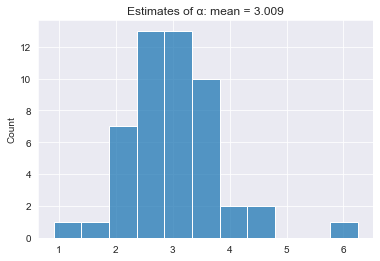

In [39]:
sns.set_style('darkgrid')
sns.histplot(outvec[:,0]).set_title("Estimates of α: mean = " + str(np.round(np.mean(outvec[:,0]),3)))

3.00934310074221 6.016044720131471
0.8375648558502539 2.013275161325079


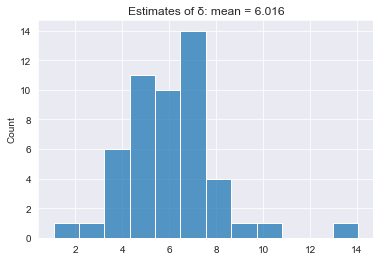

In [47]:
sns.set_style('darkgrid')
sns.histplot(outvec[:,1]).set_title("Estimates of δ: mean = " + str(np.round(np.mean(outvec[:,1]),3)))
print(np.mean(outvec[:,0]), np.mean(outvec[:,1]))
print(np.std(outvec[:,0]), np.std(outvec[:,1]))

In [19]:
# ------------------------
#     Question 1.3.4
# ------------------------

# Set parameters
α_set = 3
δ_set = 6
T = 1000
S = 50
np.random.seed(463)

##### Simulate Data for Multiple Eqs #####

# Calculating expectations of other firm's entry (all equilibria)
pme_x1_sim, pme_x2_sim = findps(α_set, δ_set)
dgp_neq = len(pme_x1_sim)
pme_x_sim = [pme_x1_sim, pme_x2_sim]

# Function to order equilibria
def sorteq(eqs):
    firmprobs = [i[0] for i in eqs]
    eqidx = np.flip(np.argsort(firmprobs))
    return [eqs[i] for i in eqidx]
    
# Function that returns probabilities for each firm given x
def pickeq(x):
    # find the possible equilibria and index them correctly
    i = x - 1
    eqs = pme_x_sim[i]
    neq = eqs.shape[0]
    ordered = sorteq(eqs)
    
    # assign eq probabilities and pick
    k2vals = [(2/(i+1)) for i in range(dgp_neq)]
    peq = expon.pdf(x, scale=k2vals)
    choice = np.random.choice(range(neq), 1, p=(peq/np.sum(peq))).item()
    
    # find firm 1 and 2 probabilities for the equilibrium
    px1 = ordered[choice][0]
    px2 = ordered[choice][1]
    return np.array((px1, px2))

# Applying to all time periods to get firm probability data
probs1_sim = np.zeros((T,S))
probs2_sim = np.zeros((T,S))
for t in range(T):
    for s in range(S):
        i = x_sim[t,s] - 1 
        p1, p2 = pickeq(x_sim[t,s])
        probs1_sim[t,s] = p1
        probs2_sim[t,s] = p2
        
# Finally constructing ys
y1me_sim = np.array((-δ_set*probs2_sim + α_set*x_sim + ϵ1_sim >= 0)*1)
y2me_sim = np.array((-δ_set*probs1_sim + α_set*x_sim + ϵ2_sim >= 0)*1)

In [20]:
soloeq1, soloeq2 = findps(3, 6)
sorteq(soloeq1)

[array([0.92928, 0.07072]), array([0.5, 0.5]), array([0.07072, 0.92928])]

In [22]:
##### Log likelihood multiple eqs #####

def me_lik(ω, y1, y2, x):
    # parse ω
    α = ω[0]
    δ = ω[1]
    
    # find ps
    p_x1, p_x2 = findps(α, δ)
    op_x1 = sorteq(p_x1)
    op_x2 = sorteq(p_x2)
    
    # handling if xs have diff eq size
    neq = max(len(p_x1), len(p_x2))
    if neq > len(p_x1):
        op_x1 = op_x1*neq
    if neq > len(p_x2):
        op_x2 = op_x2*neq
        
    # assign P based on x
    pr1 = np.zeros((x.size, neq))
    pr2 = np.zeros((x.size, neq))
    for k in range(neq):
        pr1[:,k][x==1] = op_x1[k][0]
        pr2[:,k][x==1] = op_x1[k][1]
        pr1[:,k][x==2] = op_x2[k][0]
        pr2[:,k][x==2] = op_x2[k][1]
        
    # find weights
    weights = np.zeros((x.size, neq))
    for k in range(neq):
        ki = k+1
        weights[:,k][x==1] = (ki/2)*np.exp(-ki/2)
        weights[:,k][x==2] = (ki/2)*np.exp(-ki)
    
    # likelihood
    y = np.array((y1, y2)).T.reshape(y1.size,2)
    git = np.zeros((x.size, neq, 2))
    git[:,:,0] = δ*pr1 - α*np.repeat(x, neq).reshape(x.size,neq)
    git[:,:,1] = δ*pr2 - α*np.repeat(x, neq).reshape(x.size,neq)
    loglik = np.zeros((x.size,2))
    for t in range(x.size):
        for f in range(2):
            fmin = (f+1) % 2
            ll = np.zeros(neq)
            for k in range(neq):
                ll[k] = weights[t,k]*np.power((1- expit(git[t,k,fmin])), (y[t,f])) * np.power((expit(git[t,k,fmin])), (1-y[t,f]))
            loglik[t,f] = np.log(np.sum(ll))
    
    # return
    return -np.sum(loglik)


z = 10
ω_test = np.array((1,1))
me_lik(ω_test, y1u_sim[:,z], y2u_sim[:,z], x_sim[:,z])
#me_lik(ω_test, np.array(1),np.array(1),np.array(1))
    
scipy.optimize.minimize(me_lik, ω_test,args=(y1me_sim[:,k], y2me_sim[:,k], x_sim[:,k]))

      fun: 2138.301125801535
 hess_inv: array([[0.93736439, 2.11581916],
       [2.11581916, 4.7787143 ]])
      jac: array([-32.13201904,  13.50842285])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 204
      nit: 6
     njev: 65
   status: 2
  success: False
        x: array([3.49229664, 7.04826891])

In [23]:
# Loop through all samples
testS = S
outvec_me = np.zeros((testS, 2))
for j in range(testS):
    outvec_me[j,:] = scipy.optimize.minimize(me_lik, ω_test,args=(y1me_sim[:,j], y2me_sim[:,j], x_sim[:,j])).x
    if j % 5 == 0:
        print(j, outvec_me[j,:])


0 [3.49147183 7.15819223]
5 [3.41570253 6.73772859]
10 [4.00444898 7.85771141]
15 [3.52638961 7.0674016 ]
20 [3.30203445 6.60395293]
25 [3.42065572 6.57811861]
30 [4.22821462 8.48342267]
35 [4.22614373 8.24474566]
40 [3.43965347 6.8396909 ]
45 [3.46451856 6.83088075]


Text(0.5, 1.0, 'Estimates of α: mean = 3.621')

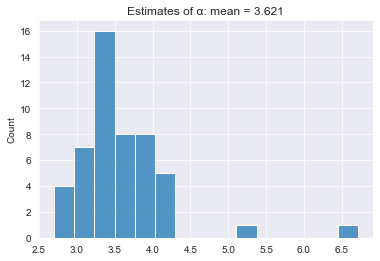

In [41]:
sns.set_style('darkgrid')
sns.histplot(outvec_me[:,0]).set_title("Estimates of α: mean = " + str(np.round(np.mean(outvec_me[:,0]),3)))

Text(0.5, 1.0, 'Estimates of δ: mean = 7.148')

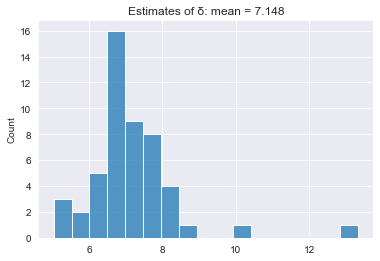

In [43]:
sns.set_style('darkgrid')
sns.histplot(outvec_me[:,1]).set_title("Estimates of δ: mean = " + str(np.round(np.mean(outvec_me[:,1]),3)))

In [45]:
print(np.mean(outvec_me[:,0]), np.mean(outvec_me[:,1]))
print(np.std(outvec_me[:,0]), np.std(outvec_me[:,1]))

3.6213058673334793 7.147682810526623
0.6219131973184181 1.2341316036271124
